In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as optim
from scipy import sparse
from matplotlib import pylab
plt.style.use('willo')

In [2]:
import matplotlib as mpl

cmapp = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['blue','black'],256)
cmapp._init()
alphas = np.linspace(0, 1, cmapp.N+3)
cmapp._lut[:,-1] = alphas

In [3]:
def model_func(x,u0,uv):
    return u0+uv*x

In [4]:
r=[]
u=[]

noffs = range(1)

for noff in noffs:
    gang = pd.read_csv('../../data/data_exp_'+str(noff)+'/gang_data.csv')
    gang['Timestamp']=pd.to_datetime([val.rsplit('-',1)[0] for val in gang['Timestamp']])
    
    r_tot = np.zeros(gang['Timestamp'].shape)
    u_tot = np.zeros(gang['Timestamp'].shape)
    n = np.zeros(gang['Timestamp'].shape)

    n = 0
    for index in range(5,11):

        pick = 'midway'+str(index).zfill(3)
        sub = pick+'|Timestamp'  
        subgang = gang.filter(regex=sub)
        subgang.columns=["".join(col.lstrip(pick).split()) for col in subgang.columns]
        if('domain_avg_power' in subgang):
            n = n+1
            val = subgang['domain_avg_power'].values
            val[np.isnan(val)]=0
            u_tot = u_tot + val
            u.extend(val)
            val = subgang['cpu_user'].values
            val[np.isnan(val)]=0
            r_tot = r_tot + val/100.
            r.extend(val/100)
            
r=np.array(r)
u=np.array(u)

In [5]:
#  c_params = optim.curve_fit(model_func,r,u,np.array([0.0,0.0]))
u0 = 96
uv = (200-96)/0.9
c_params = (np.array([u0, uv]),np.array([u0, uv]))
print c_params

(array([  96.        ,  115.55555556]), array([  96.        ,  115.55555556]))


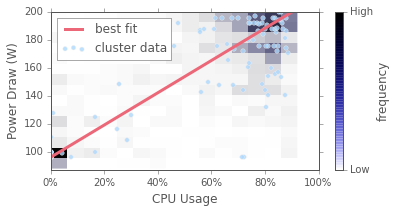

In [8]:
plt.figure(figsize=(6, 3))
rndind = np.random.choice(len(u),100)
H, xedges, yedges = np.histogram2d(r,u,bins=15)
myim = np.clip(H.T,0,100)
myim[np.isinf(myim)]=0
plt.scatter(r[rndind],u[rndind],c='#add9fe',label="cluster data",alpha=0.8)
im = plt.imshow(myim, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],aspect='auto',cmap=cmapp)
rng = np.linspace(0,1,50);
plt.plot(rng,c_params[0][0]+c_params[0][1]*rng,lw=3,c='#ec6778',label="best fit")
plt.gca().set_xlim([0,1])
plt.gca().set_xticklabels(['0%','20%','40%','60%','80%','100%'])
plt.gca().set_ylim([87,200])
plt.ylabel('Power Draw (W)')
plt.xlabel('CPU Usage')
cbar = plt.colorbar(im, ticks=[0,100], label='frequency')
cbar.ax.set_yticklabels(['Low', 'High'])
plt.legend(loc=2)
plt.gcf().subplots_adjust(bottom=0.17)
plt.savefig("../figures/pwr_proc.pdf", format='pdf', dpi=1000)

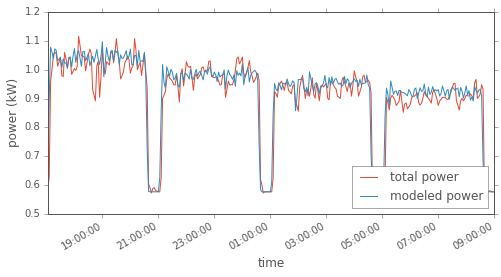

In [7]:
u0 = c_params[0][0]
uv = c_params[0][1]
u_pred = (u0*n+uv*r_tot)

fig = plt.figure(figsize=(8, 4))
plt.plot(subgang['Timestamp'],u_tot/1000,label='total power')
plt.plot(subgang['Timestamp'],u_pred/1000,label='modeled power')
# plt.ylim((0,1.1*np.max(u_tot)/1000))
plt.ylabel('power (kW)')
plt.xlabel('time')
plt.legend(loc=4)
fig.autofmt_xdate()
plt.savefig("../figures/pwr_model.pdf", format='pdf', dpi=1000)